In [1]:
import pandas as pd
import time
import skimage
from skimage.io import imread, imshow
from skimage import filters
from skimage import feature
from skimage import morphology
from skimage import measure
from skimage import exposure
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy import ndimage as ndi
import numpy as np
import pathlib as plb 
import csv
import os

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from skimage.io import imread
from skimage.util import crop
from skimage import data
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table
from skimage.color import label2rgb
from skimage import measure
from skimage.morphology import closing, square, remove_small_objects
from statistics import median


/Users/emilyfryer/anaconda3/envs/neuroplant/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
base_folder = plb.Path('/Users/emilyfryer/Documents/Current_analysis')
path_img = base_folder.joinpath('Images')
path_rslt = base_folder.joinpath('automated_results')
fig_path = base_folder.joinpath('Figures')

In [3]:
def load_image_data(path_img, image_id):
   
    fin_file = path_img.joinpath(image_id + '.tif' )
    image = skimage.io.imread(fin_file)

    return image

In [126]:
test_image = load_image_data(path_img, 'LRH/LRH_201127_001_POST')

In [127]:

label_begin = time.time()
#os.chdir(path_img)
image_nvrt = np.invert(test_image)
# apply threshold
print('At threshold')
thresh = filters.threshold_otsu(image_nvrt)
bw = closing(image_nvrt > thresh, square(10))
print(thresh)
# remove artifacts connected to image border
cleared = remove_small_objects(clear_border(bw), 1000000)
print('Clearing small objects took ', str(int(time.time() - label_begin)), 'seconds.')
#print('Image Cleared')
# label image regions
label_image = label(bw)
print('Feature finding and labeling took ', str(int(time.time() - label_begin)), 'seconds.')
#image_label_overlay = label2rgb(label_image, image=image, bg_label=0)

props = regionprops_table(label_image, properties=('label','centroid', 'bbox', 'area'))
dff=pd.DataFrame(props)

df_area = dff.sort_values(by=['area'], ascending=False).reset_index()




At threshold
127
Clearing small objects took  80 seconds.
Feature finding and labeling took  85 seconds.


In [128]:
image_center = (int(label_image.shape[1]/2),int(label_image.shape[0]/2))
print(image_center)

(5100, 7019)


In [129]:
df_area.to_csv(path_or_buf=path_rslt.joinpath('df_area.csv'))

wells = df_area[(df_area.area>= 2000000) & (df_area.area<=2500000)]
wells=wells.sort_values(by=['bbox-1'])
print('Number of wells: ' + str(len(wells)))

wells.reset_index(drop=True, inplace=True)

Number of wells: 8


In [130]:
label_image.shape

(14039, 10200)

In [131]:
#df.to_csv(path_or_buf=path_rslt.joinpath('df.csv'))
# Sort the plates into the left and right
mask1 = wells['bbox-1'] > image_center[0]
df_r = wells[mask1]
df_l = wells[~mask1]



In [132]:
## Split the right plates to upper (#1) and lower (#4)
dffr=df_r.sort_values(by=['bbox-0'])
dffr.reset_index(drop=True, inplace=True)

mask2 = df_r['bbox-0'] > image_center[1]
dff4 = df_r[mask2]
dff1 = df_r[~mask2]
dffr.head()

,index,label,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area
0,21,22,1518,7350,1080,5835,1964,8875,2360248
1,134,135,2979,7351,2530,5843,3424,8862,2327578
2,239,240,4407,7360,3966,5840,4856,8887,2372925
3,322,323,5870,7362,5436,5851,6307,8881,2330312


In [133]:





### Sort the wells on each plate
df1=dff1.sort_values(by=['bbox-0'])
df4=dff4.sort_values(by=['bbox-0'])
df4.reset_index(drop=True, inplace=True)
df1.reset_index(drop=True, inplace=True)

## Split the left plates to upper (#2) and lower (#3)
dffl=df_l.sort_values(by=['bbox-0'])
dffl.reset_index(drop=True, inplace=True)

#MinCol2=1.05*list(dffl.items())[3][1][3]
mask = df_l['bbox-0'] > image_center[1]
dff3 = df_l[mask]
dff2 = df_l[~mask]

### Sort the wells on each plate
df2=dff2.sort_values(by=['bbox-0'])
df3=dff3.sort_values(by=['bbox-0'])
df3.reset_index(drop=True, inplace=True)
df2.reset_index(drop=True, inplace=True)

## Update the label of each well
new_label_1 = pd.Series(['1A', '1B','1C','1D'], name='label', index=[0,1,2,3])
df1.update(new_label_1)

new_label_2 = pd.Series(['2A', '2B','2C','2D'], name='label', index=[0,1,2,3])
df2.update(new_label_2)

new_label_3 = pd.Series(['3A', '3B','3C','3D'], name='label', index=[0,1,2,3])
df3.update(new_label_3)

new_label_4 = pd.Series(['4A', '4B','4C','4D'], name='label', index=[0,1,2,3])
df4.update(new_label_4)


### Append the dataframes
df_f=df1.append(df2, ignore_index=True).append(df3, ignore_index=True).append(df4, ignore_index=True)
df_f["Total Worms"],df_f["Chemotaxis"], df_f["Compound"], df_f["Strain"] = [np.nan,np.nan,np.nan,np.nan] 
df_f

df_f = df_f.rename(columns={'label': 'WellNo'})
#df_f.drop(['centroid-0', 'centroid-1', 'bbox-0', 'bbox-1', 'bbox-2', 'bbox-3', 'area'], axis=1, inplace=True)


In [134]:
df_f

,index,WellNo,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area,Total Worms,Chemotaxis,Compound,Strain
0,21,1A,1518,7350,1080,5835,1964,8875,2360248,NaN,NaN,NaN,NaN
1,134,1B,2979,7351,2530,5843,3424,8862,2327578,NaN,NaN,NaN,NaN
2,239,1C,4407,7360,3966,5840,4856,8887,2372925,NaN,NaN,NaN,NaN
3,322,1D,5870,7362,5436,5851,6307,8881,2330312,NaN,NaN,NaN,NaN
4,16,2A,1519,2889,1068,1353,1965,4412,2350229,NaN,NaN,NaN,NaN
5,123,2B,2942,2868,2490,1331,3399,4402,2383003,NaN,NaN,NaN,NaN
6,235,2C,4409,2885,3956,1363,4858,4395,2332031,NaN,NaN,NaN,NaN
7,321,2D,5877,2836,5436,1301,6318,4372,2373302,NaN,NaN,NaN,NaN


In [135]:
def calc_chemotaxis_index(filtered_worm, dims):
    
    ## Assign features to zones of the plate
    left_area_boundary = int(4/9*dims[1])#int(3424*4/9) #8000
    #print(left_area_boundary)
    right_area_boundary = int(5/9*dims[1])#int(3424*5/9)
    #print(right_area_boundary)

    left_side_worms = filtered_worm[filtered_worm['centroid-1'] <= left_area_boundary]
    middle_w = filtered_worm[filtered_worm['centroid-1'] < right_area_boundary]
    middle_worms = middle_w[middle_w['centroid-1'] >left_area_boundary]
    right_side_worms = filtered_worm[filtered_worm['centroid-1'] >= right_area_boundary]

    ## Calculate chemotaxis index
    worms_in_left_region = len(left_side_worms)
    worms_in_middle_region = len(middle_worms)
    worms_in_right_region = len(right_side_worms)
    total_worms_found = len(filtered_worm)
    #print('Left; ' + str(worms_in_left_region) + '   Right: ' + str(worms_in_right_region))

    try:
        chemotaxis_index = ((worms_in_left_region - worms_in_right_region) 
                        / (worms_in_left_region + worms_in_right_region))
        return chemotaxis_index

    except ZeroDivisionError:
        return 0
    



In [136]:
def loopWell(df_f,image,path_rslt, fig_path):

    for well in range(len(df_f)):

#     fin_image = image[ df_f[][]:Lower_boundary , Left_boundary:Right_boundary ]
        #new_image=np.invert(image)
        fin_image = image[ df_f['bbox-0'][well]:df_f['bbox-2'][well], df_f['bbox-1'][well]:df_f['bbox-3'][well]]
        #imshow(fin_image)
        wellno = df_f['WellNo'][well]
        image_dims = fin_image.shape
        print(wellno)

        
        thresh = skimage.filters.threshold_otsu(fin_image)
        print('Threshold:' + str(thresh))
        binarized = fin_image > thresh
        
        ## Find features in binary image
        labeled_array, num_features = ndi.label(binarized)
        props_worm = regionprops_table(label_image=labeled_array, properties=('label','centroid', 'area'))
        worms=pd.DataFrame(props_worm)
        
        # label image regions
        #label_image = label(cleare)
        #image_label_overlayy = label2rgb(label_image, image=fin_image, bg_label=0)
        filt_worm=worms[worms['area']<2500]
        filtered_worm=filt_worm[filt_worm['area']>50]


        print(len(filtered_worm))
        
        fig, axes = plt.subplots(figsize=(8, 16), constrained_layout=True)
        axes.imshow(binarized)
        axes.set_title(wellno)
        sns.scatterplot(x='centroid-1', y='centroid-0', ax=axes, data=filtered_worm, s=10,color='red',edgecolor='none', legend=False )
        #fig.savefig(fig_path.joinpath(wellno), orientation='landscape')
        
        tw = len(filtered_worm)
        CI = calc_chemotaxis_index(filtered_worm,image_dims)
        df_f.loc[df_f['WellNo'] == wellno, 'Chemotaxis'] = CI
        df_f.loc[df_f['WellNo'] == wellno, 'Total Worms'] = tw
    df_f.to_csv(path_or_buf= path_rslt.joinpath('LRH_201127_001.csv'))
        #save_worm_locations(df_f,filtered_worm,path_rslt,label)


1A
Threshold:104
482
1B
Threshold:106
452
1C
Threshold:106
386
1D
Threshold:104
522
2A
Threshold:111
455
2B
Threshold:107
435
2C
Threshold:114
287
2D
Threshold:109
432


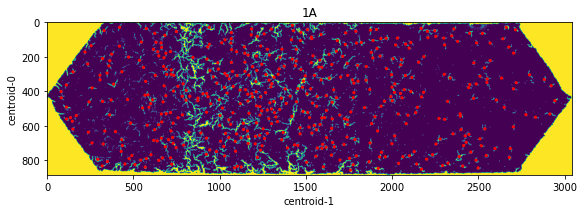

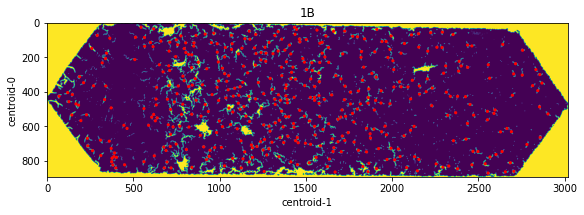

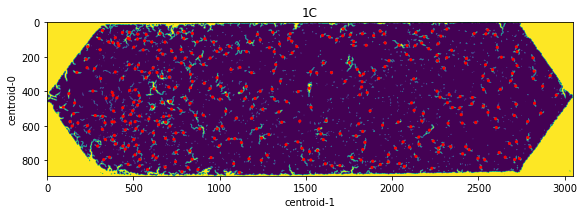

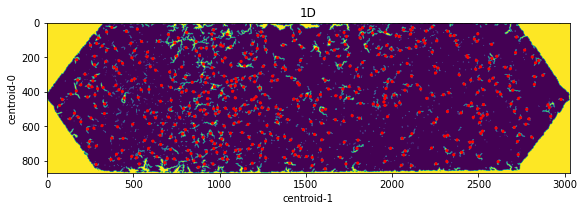

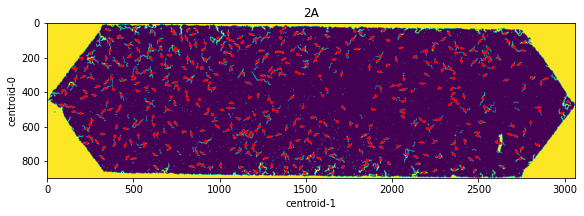

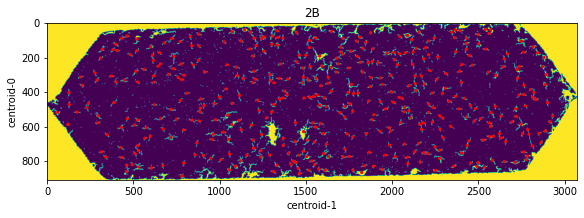

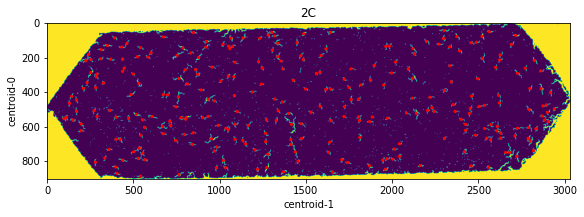

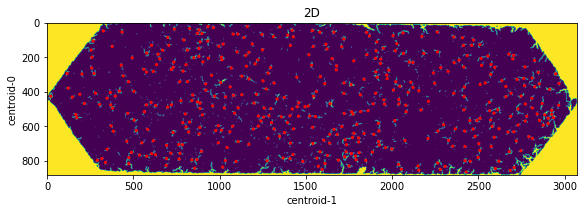

In [137]:
loopWell(df_f, test_image, path_rslt, fig_path)

(7298, 1204)


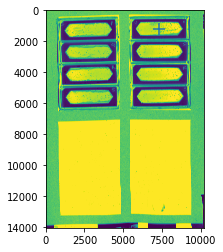

In [29]:
center_mass = (df_area['centroid-1'][1], df_area['centroid-0'][1])
print(center_mass)
fig, ax = plt.subplots()
ax.imshow(image_nvrt)
# Note the inverted coordinates because plt uses (x, y) while NumPy uses (row, column)
ax.scatter(center_mass[0], center_mass[1], s=160, c='C0', marker='+')
plt.show()

In [35]:
df_f.head()

,index,WellNo,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area,Total Worms,Chemotaxis,Compound,Strain
0,26,1A,1460,7624,1011,6102,1909,9147,2344881,97.0,0.692308,NaN,NaN
1,108,1B,2943,7608,2491,6096,3409,9154,2350352,168.0,0.444444,NaN,NaN
2,240,1C,4359,7623,3886,6120,4827,9160,2335264,120.0,0.821429,NaN,NaN
3,309,1D,5813,7627,5359,6122,6260,9161,2330419,108.0,0.942308,NaN,NaN
4,9,2A,1455,2579,1001,1037,1913,4098,2306283,213.0,0.045685,NaN,NaN


In [41]:
def slots_wells(row):
    row['Slot'] = row['WellNo'][0]
    row['Well'] = row['WellNo'][1]
    return row

In [42]:
df_f.apply(lambda row: slots_wells(row), axis=1)

,index,WellNo,centroid-0,centroid-1,bbox-0,bbox-1,bbox-2,bbox-3,area,Total Worms,Chemotaxis,Compound,Strain,Slot,Well
0,26,1A,1460,7624,1011,6102,1909,9147,2344881,97.0,0.692308,NaN,NaN,1,A
1,108,1B,2943,7608,2491,6096,3409,9154,2350352,168.0,0.444444,NaN,NaN,1,B
2,240,1C,4359,7623,3886,6120,4827,9160,2335264,120.0,0.821429,NaN,NaN,1,C
3,309,1D,5813,7627,5359,6122,6260,9161,2330419,108.0,0.942308,NaN,NaN,1,D
4,9,2A,1455,2579,1001,1037,1913,4098,2306283,213.0,0.045685,NaN,NaN,2,A
5,103,2B,2907,2572,2459,1033,3364,4104,2335698,234.0,-0.236181,NaN,NaN,2,B
6,226,2C,4295,2565,3840,1032,4752,4072,2345940,145.0,0.349206,NaN,NaN,2,C
7,335,2D,5831,2596,5392,1060,6281,4111,2303496,191.0,0.074286,NaN,NaN,2,D
8,438,3A,8396,2552,7942,1006,8854,4095,2408110,176.0,-0.075862,NaN,NaN,3,A
9,522,3B,9914,2546,9470,990,10369,4078,2369084,168.0,0.372549,NaN,NaN,3,B


In [43]:
test_dict = {'-StrainP-': '', '-StrainQ-': '', '-StrainR-': '', '-StrainS-': '', 
 '-PID1-': '1', '-Compound1-': 'DMSO', '-PID2-': '2', '-Compound2-': 'H2O', '-PID3-': '3',
 '-Compound3-': 'EtOH', '-PID4-': '4', '-Compound4-': 'DMSO',
 '-results-': '/Users/emilyfryer/Documents/Current_analysis/automated_results',
 'Browse': '/Users/emilyfryer/Documents/Current_analysis/automated_results', '-file-': '/Users/emilyfryer/Documents/Current_analysis/Images/NPP_201116_01_fin036.tif', 'Browse0': '/Users/emilyfryer/Documents/Current_analysis/Images/NPP_201116_01_fin036.tif'}